<a href="https://colab.research.google.com/github/szuhow/corona/blob/main/coronary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-model-summary

In [ ]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import cv2
import os,sys
import re
import pandas as pd
import matplotlib.pyplot as plt
import glob
import math
import json
import warnings
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.transforms.functional import to_tensor, to_pil_image
from pytorch_model_summary import summary


In [ ]:
import torch
if torch.cuda.is_available():
    print(f'PyTorch is using GPU: {torch.cuda.get_device_name(0)}')
else:
    print('GPU not available')

GPU not available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/train_voc'

In [ ]:
def natural_sort_key(s):
    """
    Function to generate a natural sort key.
    """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

In [ ]:
image_dir = sorted(glob.glob(os.path.join(path, 'images/*')), key=natural_sort_key)
mask_dir = sorted(glob.glob(os.path.join(path, 'masks/*')), key=natural_sort_key)

In [ ]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
import logging

# Set up a basic logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        print(f"Input shape: {x.shape}")  # Log input shape
        conv1 = self.dconv_down1(x)
        print(f"conv1 shape: {conv1.shape}")  # Log conv1 shape
        x = self.maxpool(conv1)
        print(f"maxpool1 shape: {x.shape}")  # Log maxpool1 shape

        conv2 = self.dconv_down2(x)
        print(f"conv2 shape: {conv2.shape}")  # Log conv2 shape
        x = self.maxpool(conv2)
        print(f"maxpool2 shape: {x.shape}")  # Log maxpool2 shape

        conv3 = self.dconv_down3(x)
        print(f"conv3 shape: {conv3.shape}")  # Log conv3 shape
        x = self.maxpool(conv3)
        print(f"maxpool3 shape: {x.shape}")  # Log maxpool3 shape

        x = self.dconv_down4(x)
        print(f"dconv_down4 shape: {x.shape}")  # Log dconv_down4 shape

        x = self.upsample(x)
        print(f"upsample1 shape: {x.shape}")  # Log upsample1 shape
        x = torch.cat([x, conv3], dim=1)
        print(f"cat1 shape: {x.shape}")  # Log cat1 shape

        x = self.dconv_up3(x)
        print(f"dconv_up3 shape: {x.shape}")  # Log dconv_up3 shape
        x = self.upsample(x)
        print(f"upsample2 shape: {x.shape}")  # Log upsample2 shape
        x = torch.cat([x, conv2], dim=1)
        print(f"cat2 shape: {x.shape}")  # Log cat2 shape

        x = self.dconv_up2(x)
        print(f"dconv_up2 shape: {x.shape}")  # Log dconv_up2 shape
        x = self.upsample(x)
        print(f"upsample3 shape: {x.shape}")  # Log upsample3 shape
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
len_data = len(image_dir)
train_size = 0.6

train_image_paths = image_dir[:int(len_data*train_size)]
test_image_paths = image_dir[int(len_data*train_size):]

train_mask_paths = mask_dir[:int(len_data*train_size)]
test_mask_paths = mask_dir[int(len_data*train_size):]

In [ ]:
class CoronaryDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True):
        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transforms = transforms.Compose([
            transforms.Grayscale(),  # Convert to grayscale
            transforms.Resize((256, 256)),  # Resize to 512x512
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        # Load image and mask
        image = Image.open(self.image_paths[index]).convert('RGB')  # Ensure RGB mode
        mask = Image.open(self.target_paths[index]).convert('RGB')  # Ensure RGB mode

        # Extract red channel from mask and copy to green and blue
        mask_np = np.array(mask)  # Convert to NumPy array
        red_channel = mask_np[:, :, 0]  # Extract red channel
        mask_np[:, :, 1] = red_channel  # Copy to green channel
        mask_np[:, :, 2] = red_channel  # Copy to blue channel

        # Convert back to PIL image and apply transformations
        updated_mask = Image.fromarray(mask_np)
        t_image = self.transforms(image)
        t_mask = self.transforms(updated_mask)

        # Binarize the mask if needed (e.g., threshold)
        # t_mask = (t_mask > 0.5).type(torch.float32)

        return [t_image, t_mask]

    def __len__(self):
        return len(self.image_paths)

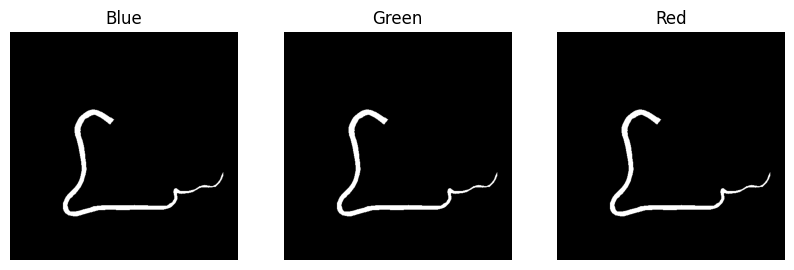

In [ ]:
# # image = cv2.imread(train_mask_paths[0], cv2.IMREAD_UNCHANGED)  # Load with transparency if available

# # # Check if the image has an alpha channel
# # has_alpha = image.shape[2] == 4

# # Split into channels
# channels = cv2.split(np.array(mask))  # Returns a list of channels (B, G, R, [A])

# # Visualize the channels
# channel_names = ["Blue", "Green", "Red"] + (["Alpha"] if has_alpha else [])
# plt.figure(figsize=(10, 5))
# for i, channel in enumerate(channels):
#     plt.subplot(1, len(channels), i + 1)
#     plt.title(channel_names[i])
#     plt.imshow(channel, cmap='gray')
#     plt.axis('off')

# plt.show()

In [ ]:
print(summary(UNet(1), torch.zeros((16, 1, 256,256)), show_input=True))

---------------------------------------------------------------------------
      Layer (type)             Input Shape         Param #     Tr. Param #
          Conv2d-1       [16, 1, 256, 256]             640             640
            ReLU-2      [16, 64, 256, 256]               0               0
          Conv2d-3      [16, 64, 256, 256]          36,928          36,928
            ReLU-4      [16, 64, 256, 256]               0               0
       MaxPool2d-5      [16, 64, 256, 256]               0               0
          Conv2d-6      [16, 64, 128, 128]          73,856          73,856
            ReLU-7     [16, 128, 128, 128]               0               0
          Conv2d-8     [16, 128, 128, 128]         147,584         147,584
            ReLU-9     [16, 128, 128, 128]               0               0
         Conv2d-10       [16, 128, 64, 64]         295,168         295,168
           ReLU-11       [16, 256, 64, 64]               0               0
         Conv2d-12      

In [ ]:
batch_size = 16

train_dataset = CoronaryDataset(train_image_paths, train_mask_paths, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

test_dataset = CoronaryDataset(test_image_paths, test_mask_paths, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

image_datasets = {
    'train': train_dataset, 'val': test_dataset
}
dataloaders = {
    'train': train_loader,
    'val': test_loader
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

import copy
import time
from collections import defaultdict

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

# def dice_loss(pred, target, smooth=1e-5):
#     """Calculate Dice loss for binary segmentation."""
#     intersection = (pred * target).sum()
#     return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    """Calculate combined BCE and Dice loss with metrics tracking."""
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred_sigmoid = torch.sigmoid(pred)
    dice = dice_loss(pred_sigmoid, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    # Update metrics (detach to prevent gradient tracking)
    with torch.no_grad():
        metrics['bce'] += bce.item() * target.size(0)
        metrics['dice'] += dice.item() * target.size(0)
        metrics['loss'] += loss.item() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    """Print formatted metrics for the current phase."""
    outputs = [f"{k}: {metrics[k] / epoch_samples:.4f}" for k in metrics.keys()]
    print(f"{phase}: {', '.join(outputs)}")

def train_model(model, dataloaders, optimizer, scheduler, device, num_epochs=15, accumulation_steps=2):
    """Comprehensive model training function with validation."""
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        since = time.time()

        # Training and validation phases
        for phase in ['train', 'val']:
            # Adjust learning rate and model mode
            if phase == 'train':
                scheduler.step()
                model.train()
                print("LR:", optimizer.param_groups[0]['lr'])
            else:
                model.eval()

            # Reset metrics for current phase
            metrics = defaultdict(float)
            epoch_samples = 0

            # Disable gradient computation for validation
            with torch.set_grad_enabled(phase == 'train'):
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # loss = loss / accumulation_steps  # Scale loss to account for accumulation
                    # loss.backward()

                    # if (i + 1) % accumulation_steps == 0:  # Update weights every accumulation_steps
                    #     optimizer.step()

                    # Backward pass and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # Update statistics
                    epoch_samples += inputs.size(0)

            # Print and track phase metrics
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # Save best model
            if phase == 'val' and epoch_loss < best_loss:
                print("Saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        # Print epoch time
        time_elapsed = time.time() - since
        print(f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    print(f'Best val loss: {best_loss:.4f}')
    model.load_state_dict(best_model_wts)
    return model

def setup_training(model, learning_rate=1e-2, step_size=25, gamma=0.1):
    """Setup optimizer and learning rate scheduler."""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    return model, optimizer, scheduler, device



In [ ]:
model = UNet(1)  # Replace with your model

  # Prepare training components
model, optimizer, scheduler, device = setup_training(model)

# Prepare dataloaders for train and validation
# Train the model
trained_model = train_model(
    model,
    dataloaders,
    optimizer,
    scheduler,
    device
)

Epoch 0/14
----------
LR: 0.01


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Input shape: torch.Size([16, 1, 256, 256])
conv1 shape: torch.Size([16, 64, 256, 256])
maxpool1 shape: torch.Size([16, 64, 128, 128])
conv2 shape: torch.Size([16, 128, 128, 128])
maxpool2 shape: torch.Size([16, 128, 64, 64])
conv3 shape: torch.Size([16, 256, 64, 64])
maxpool3 shape: torch.Size([16, 256, 32, 32])
dconv_down4 shape: torch.Size([16, 512, 32, 32])
upsample1 shape: torch.Size([16, 512, 64, 64])
cat1 shape: torch.Size([16, 768, 64, 64])
dconv_up3 shape: torch.Size([16, 256, 64, 64])
upsample2 shape: torch.Size([16, 256, 128, 128])
cat2 shape: torch.Size([16, 384, 128, 128])
dconv_up2 shape: torch.Size([16, 128, 128, 128])
upsample3 shape: torch.Size([16, 128, 256, 256])
Input shape: torch.Size([16, 1, 256, 256])
conv1 shape: torch.Size([16, 64, 256, 256])
maxpool1 shape: torch.Size([16, 64, 128, 128])
conv2 shape: torch.Size([16, 128, 128, 128])
maxpool2 shape: torch.Size([16, 128, 64, 64])
conv3 shape: torch.Size([16, 256, 64, 64])
maxpool3 shape: torch.Size([16, 256, 32, 3

--------------------------------------------------------------------------------------


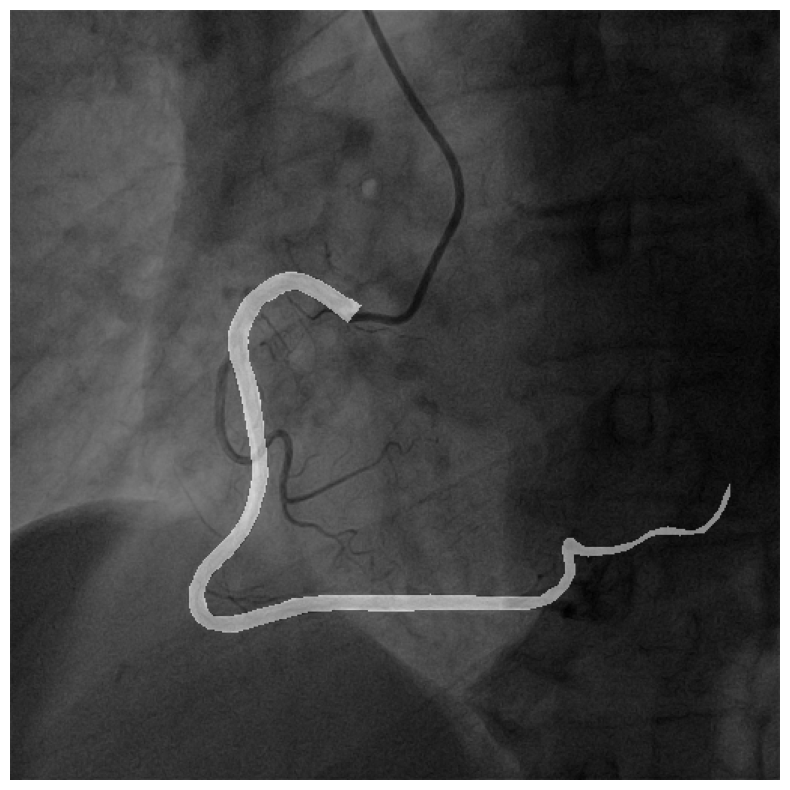

In [ ]:
# show first image
image, mask = train_dataset[0]



# Convert the image and mask to NumPy arrays
image_np = image.squeeze().numpy()
mask_np = mask.squeeze().numpy()
# image_np
# # Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# # Display the image
ax.imshow(image_np, cmap='gray')

# # Overlay the mask with some transparency
ax.imshow(mask_np, cmap='gray', alpha=0.5)  # 'jet' colormap for the mask

# # Hide the axis
ax.axis('off')

# # Show the plot
plt.show()

In [ ]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

In [ ]:
# from collections import defaultdict
# import torch.nn.functional as F
# def dice_loss(pred, target, smooth = 1.):
#     pred = pred.contiguous()
#     target = target.contiguous()

#     intersection = (pred * target).sum(dim=2).sum(dim=2)

#     loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

#     return loss.mean()
# def calc_loss(pred, target, metrics, bce_weight=0.5):
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     pred = F.sigmoid(pred)
#     dice = dice_loss(pred, target)

#     loss = bce * bce_weight + dice * (1 - bce_weight)

#     metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
#     metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
#     metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

#     return loss

# def print_metrics(metrics, epoch_samples, phase):
#     outputs = []
#     for k in metrics.keys():
#         outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

#     print("{}: {}".format(phase, ", ".join(outputs)))

# def train_model(model, optimizer, scheduler, num_epochs=25):
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 1e10

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

#         since = time.time()

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 scheduler.step()
#                 for param_group in optimizer.param_groups:
#                     print("LR", param_group['lr'])

#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             metrics = defaultdict(float)
#             epoch_samples = 0

#             for inputs, labels in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # zero the parameter gradients
#                 optimizer.zero_grad()

#                 # forward
#                 # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)
#                     loss = calc_loss(outputs, labels, metrics)

#                     # backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                 # statistics
#                 epoch_samples += inputs.size(0)

#             print_metrics(metrics, epoch_samples, phase)
#             epoch_loss = metrics['loss'] / epoch_samples

#             # deep copy the model
#             if phase == 'val' and epoch_loss < best_loss:
#                 print("saving best model")
#                 best_loss = epoch_loss
#                 best_model_wts = copy.deepcopy(model.state_dict())

#         time_elapsed = time.time() - since
#         print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val loss: {:4f}'.format(best_loss))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model


In [ ]:
# import torch
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import time
# import copy

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# num_class = 1

# model = UNet(num_class).to(device)

# # Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

# model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001


KeyboardInterrupt: 

In [ ]:
def set_memory_management():
    # Configure PyTorch CUDA memory allocation
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
set_memory_management()


In [ ]:
torch.save(trained_model.state_dict(), "best_model.pth")

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Example inference
with torch.no_grad():
    sample_input = torch.rand(1, 1, 128, 128).to(device)
    output = model(sample_input)
    print(output.shape)

torch.Size([1, 1, 128, 128])


<ipython-input-236-9f90ef421dfe>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


In [ ]:
image_path = "/content/drive/MyDrive/train_voc/JPEGImages/125.jpg"  # Replace with your image file path
image = Image.open(image_path).convert('L')  # Convert to grayscale if needed

# Step 2: Preprocess the image
transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Resize to the model's input size
    transforms.ToTensor(),         # Convert to a PyTorch tensor
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])
input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

<ipython-input-248-2d620a81f972>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))  # Load trained weights


Output min: 0
Output max: 255
Output mean: 34.7066535949707


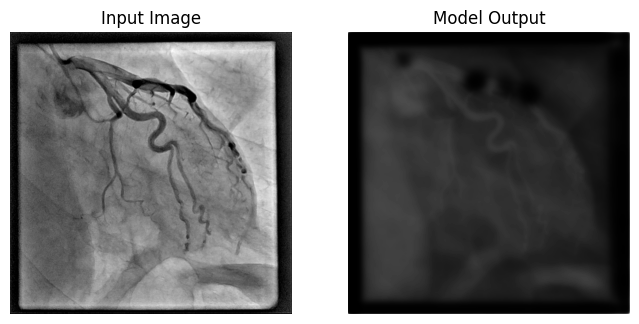

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))  # Load trained weights
model.eval()  # Set to evaluation mode

# Step 4: Run inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_tensor = input_tensor.to(device)
model = model.to(device)

with torch.no_grad():
    output = model(input_tensor)

# Step 5: Process the output
output = torch.sigmoid(output)  # Apply sigmoid if binary segmentation
output_image = output.squeeze().cpu().numpy()  # Convert back to numpy for visualization
output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min()) * 255
output_image = output_image.astype('uint8')
print("Output min:", output_image.min())
print("Output max:", output_image.max())
print("Output mean:", output_image.mean())
# Visualize the output (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Model Output")
plt.imshow(output_image,cmap='gray')
plt.axis('off')

plt.show()